In [2]:
import plotly.express as px
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import matplotlib.pyplot as plt
import geojsoncontour

In [3]:
import pandas as pd
import numpy as np
import re
import json
from datetime import datetime

from scipy.interpolate import griddata
from numpy import linspace

In [268]:
# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

# Set global theme

import plotly.figure_factory as ff

import plotly.graph_objects as go

#Selecting a central city point to center all graphs around - Swietokrzyska Subway 
center_coors=52.235176, 21.008393

In [124]:
import random
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_excel(r"https://raw.githubusercontent.com/Jan-Majewski/Project_Portfolio/master/03_Real_Estate_pricing_in_Warsaw/RE_models_input_enriched.xlsx")

In [6]:
df.columns

Index(['Id', 'Area', 'Price', 'latitude', 'longitude', 'build_year',
       'building_floors_num', 'rooms_num', 'City', 'subdistrict', 'market',
       'Building_material', 'Building_ownership', 'Building_type',
       'Construction_status', 'floor_no', 'Heating', 'Windows_type',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_attic', 'Extras_types_balcony', 'Extras_types_basement',
       'Extras_types_garage', 'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_separate_kitchen', 'Extras_types_terrace',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_cable-television', 'Media_types_electricity',
       'Media_types_internet', 'Media_types_phone', 'Media_types_sewage',
       'Media_types_water', 'Security_types_alarm

In [7]:
base_columns=['Id', 'Area', 'Price', 'latitude', 'longitude', 'build_year',
       'market', 'district', 'unit_price', 'lon_mod', 'lat_mod', 'grid_price',
       'sample_size', 'distance_transit_8AM', 'time_transit_8AM',
       'distance_driving_8AM', 'time_driving_8AM',
       'distance_return_transit_5PM', 'time_return_transit_5PM',
       'distance_return_driving_5PM', 'time_return_driving_5PM',
       'restaurant_price_level', 'restaurant_mean_rating',
       'restaurant_mean_popularity', 'restaurant_count']

In [8]:
df=df[base_columns]

In [9]:
df.shape

(11788, 25)

In [11]:
df_map=df.groupby(['lon_mod', 'lat_mod'],as_index=False).mean()

In [13]:
df_map.head()

,lon_mod,lat_mod,Id,Area,Price,latitude,longitude,build_year,unit_price,grid_price,...,distance_driving_8AM,time_driving_8AM,distance_return_transit_5PM,time_return_transit_5PM,distance_return_driving_5PM,time_return_driving_5PM,restaurant_price_level,restaurant_mean_rating,restaurant_mean_popularity,restaurant_count
0,20.835,52.1925,6.044696e+07,36.000000,299000.000000,52.191268,20.832606,2012.000000,8305.000000,8305.000000,...,14.700,27.666667,15.242,50.250000,18.236,24.150000,1.5,3.350,201.166667,6.0
1,20.850,52.1925,6.045811e+07,54.970000,459000.000000,52.189112,20.849917,1974.000000,8349.500000,8349.500000,...,14.003,27.250000,14.836,48.266667,14.866,23.216667,1.5,3.350,201.166667,6.0
2,20.850,52.2000,6.044745e+07,67.066667,635000.000000,52.198456,20.856400,2013.333333,9515.000000,9515.000000,...,12.568,25.316667,13.661,52.416667,12.571,23.633333,1.5,3.350,201.166667,6.0
3,20.865,52.1850,6.048529e+07,65.059310,515701.655172,52.187444,20.869715,2014.034483,7998.482759,7998.482759,...,13.200,24.016667,12.362,39.900000,12.917,21.383333,1.5,3.350,201.166667,6.0
4,20.865,52.1925,6.043365e+07,62.745000,508247.090909,52.192833,20.866064,2000.454545,8062.136364,8062.136364,...,12.482,26.000000,11.774,32.833333,13.483,22.150000,1.6,4.425,205.500000,8.0


In [14]:
df_map.columns

Index(['lon_mod', 'lat_mod', 'Id', 'Area', 'Price', 'latitude', 'longitude',
       'build_year', 'unit_price', 'grid_price', 'sample_size',
       'distance_transit_8AM', 'time_transit_8AM', 'distance_driving_8AM',
       'time_driving_8AM', 'distance_return_transit_5PM',
       'time_return_transit_5PM', 'distance_return_driving_5PM',
       'time_return_driving_5PM', 'restaurant_price_level',
       'restaurant_mean_rating', 'restaurant_mean_popularity',
       'restaurant_count'],
      dtype='object')

# Dividing data into deciles

In [226]:
# Highest values should receive top score
normal_buckets=['restaurant_price_level',
       'restaurant_mean_rating', 'restaurant_mean_popularity',
       'restaurant_count','build_year']

In [701]:
normal_labels=np.ones([100,])
for i in range(0,normal_labels.shape[0]):
    normal_labels[i]=i+1

In [702]:
normal_labels

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [703]:
# Lowest values should receive top score
reversed_buckets=['unit_price','distance_transit_8AM', 'time_transit_8AM', 'distance_driving_8AM',
       'time_driving_8AM', 'distance_return_transit_5PM',
       'time_return_transit_5PM', 'distance_return_driving_5PM',
       'time_return_driving_5PM',"Price","Area"]

In [705]:
reversed_labels=np.ones([100,])
for i in range(0,reversed_labels.shape[0]):
    reversed_labels[i]=normal_labels[99-i]


In [706]:
reversed_labels

array([100.,  99.,  98.,  97.,  96.,  95.,  94.,  93.,  92.,  91.,  90.,
        89.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,  81.,  80.,  79.,
        78.,  77.,  76.,  75.,  74.,  73.,  72.,  71.,  70.,  69.,  68.,
        67.,  66.,  65.,  64.,  63.,  62.,  61.,  60.,  59.,  58.,  57.,
        56.,  55.,  54.,  53.,  52.,  51.,  50.,  49.,  48.,  47.,  46.,
        45.,  44.,  43.,  42.,  41.,  40.,  39.,  38.,  37.,  36.,  35.,
        34.,  33.,  32.,  31.,  30.,  29.,  28.,  27.,  26.,  25.,  24.,
        23.,  22.,  21.,  20.,  19.,  18.,  17.,  16.,  15.,  14.,  13.,
        12.,  11.,  10.,   9.,   8.,   7.,   6.,   5.,   4.,   3.,   2.,
         1.])

In [707]:
noise=np.random.rand(df_map.shape[0],df_map.shape[1]-3)/10000

In [708]:
df_map.iloc[:,3:]=df_map.iloc[:,3:]+noise

In [709]:
df_dec=df_map.iloc[:,:3]

In [710]:
bin_count=10

for feature in normal_buckets:
    df_dec[feature]=pd.qcut(df_map[feature],100,labels=normal_labels).astype(int)
    
for feature in reversed_buckets:
    df_dec[feature]=pd.qcut(df_map[feature],100,labels=reversed_labels).astype(int)

In [711]:
df_dec["filter_unit_price"]=df_map.unit_price
df_dec["filter_transit_time"]=(df_map.time_transit_8AM+df_map.time_return_transit_5PM)/2
df_dec["filter_driving_time"]=(df_map.time_driving_8AM+df_map.time_return_driving_5PM)/2
df_dec["filter_distance"]=df_map.distance_driving_8AM

# Creating key KPIs

## Transport KPI

In [712]:
car_ratio=0.2
commute_ratio=1-car_ratio

In [713]:
df_dec["KPI_transport"]=df_dec.time_driving_8AM*car_ratio+df_dec.time_transit_8AM*commute_ratio

## Culture KPI

In [714]:
restaurant_popularity_share=0.2
restaurant_rating_share=0.3
restaurant_count_share=0.4
restaurant_price_share=1-restaurant_popularity_share-restaurant_rating_share-restaurant_count_share

In [715]:
df_dec["KPI_Culture"]=df_dec.restaurant_mean_popularity*restaurant_popularity_share\
                        +df_dec.restaurant_mean_rating*restaurant_rating_share\
                        +df_dec.restaurant_count*restaurant_count_share\
                        +df_dec.restaurant_price_level*restaurant_price_share

## Price KPI

In [716]:
unit_price_ratio=1
abs_price_ratio=1-unit_price_ratio

In [717]:
df_dec["KPI_Price"]=df_dec.unit_price*unit_price_ratio+df_dec.Price*abs_price_ratio

In [718]:
df_dec[["KPI_Price","KPI_transport","KPI_Culture"]]

,KPI_Price,KPI_transport,KPI_Culture
0,76,7.0,46.7
1,75,4.0,46.8
2,56,6.0,36.1
3,81,31.2,43.7
4,81,15.0,79.3
...,...,...,...
405,77,11.2,21.3
406,74,27.8,85.9
407,75,12.8,48.5
408,70,10.4,35.5


# Visualizing optimal area

In [720]:
def create_geojson(x,y,z, rescale):
    xi = linspace(x.min(),x.max(),50);
    yi = linspace(y.min(),y.max(),50);
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method="linear")

   
    cs = plt.contourf(xi,yi,zi,range(int(np.nanmin(zi)),int(np.nanmax(zi))+5,5),cmap=plt.cm.jet)
    
    
    
    

    geojson = geojsoncontour.contourf_to_geojson(
    contourf=cs,
    ndigits=3,
   
    )

    json_dict=eval(geojson)
    
    arr_temp=np.ones([len(json_dict["features"]),2])
    
    for i in range(0, len(json_dict["features"])):
        json_dict["features"][i]["id"]=i

    
        arr_temp[i,0]=i
        arr_temp[i,1]=float(json_dict["features"][i]["properties"]["title"])/rescale
    
    df_contour=pd.DataFrame(arr_temp, columns=["Id","value"])
   
    
    return(json_dict, df_contour)

In [724]:
def plot_geojson_countour(geojson, df, title):
    trace = go.Choroplethmapbox(
                                geojson=geojson,
                                locations=df.Id,
                                z=df.value,
                                colorscale="jet",
                                zauto=False,
                                zmax=5,


                                marker_line_width=0,

                                marker=dict(opacity=0.5),

                               )
    layout = go.Layout(
        title=title,




        height = 800,
        # top, bottom, left and right margins
        margin = dict(t = 80, b = 0, l = 0, r = 0),
        font = dict(color = 'dark grey', size = 18),

        mapbox = dict(


            center = dict(
                lat = center_coors[0],
                lon = center_coors[1]
            ),
            # default level of zoom
            zoom = 10,
            # default map style
            style = "carto-positron"
        )

    )

    figure=dict(
        data=[trace],
        layout=layout,


        )

    iplot(figure)

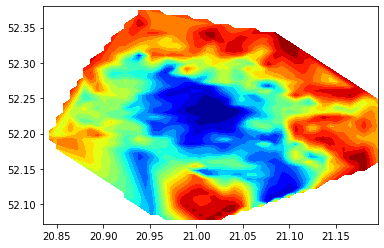

In [725]:
json_dict_price, df_contour_price=create_geojson(df_dec.lon_mod,df_dec.lat_mod,df_dec.KPI_Price,20)

In [726]:
plot_geojson_countour(json_dict_price, df_contour_price, "Price KPI heatmap")

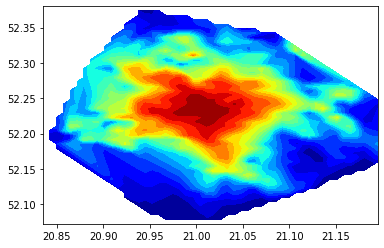

In [731]:
json_dict_transport, df_contour_transport=create_geojson(df_dec.lon_mod,df_dec.lat_mod,df_dec.KPI_transport,20)

In [732]:
plot_geojson_countour(json_dict_transport, df_contour_transport, "Transport Heatmap")

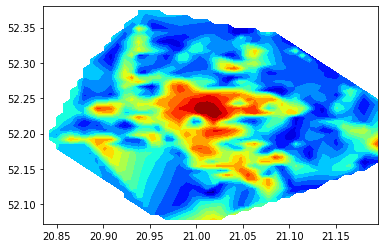

In [733]:
json_dict_culture, df_contour_culture=create_geojson(df_dec.lon_mod,df_dec.lat_mod,df_dec.KPI_Culture,20)

In [734]:
plot_geojson_countour(json_dict_culture, df_contour_culture, "Culture Heatmap")

# Final score

In [766]:
price_share=0.5
transport_share=0.5
culture_share=1-price_share-transport_share

In [767]:
df_dec["KPI_Summary"]=df_dec.KPI_Price*price_share+df_dec.KPI_transport*transport_share+df_dec.KPI_Culture*culture_share

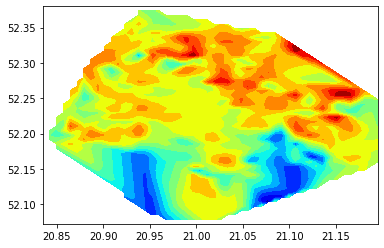

In [768]:
json_dict_summary, df_contour_summary=create_geojson(df_dec.lon_mod,df_dec.lat_mod,df_dec.KPI_Summary,20)

In [769]:
plot_geojson_countour(json_dict_summary, df_contour_summary, "Optimal location")

## Filter by price

In [770]:
price_limit=10000

In [771]:
df_dec["KPI_Summary"]=np.where(df_dec.filter_unit_price<=price_limit,df_dec.KPI_Summary,np.NaN)

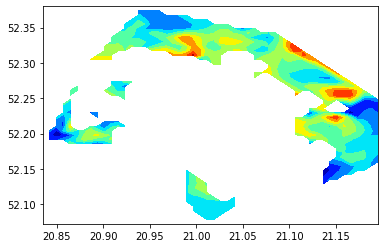

In [772]:
json_dict_summary, df_contour_summary=create_geojson(df_dec.lon_mod,df_dec.lat_mod,df_dec.KPI_Summary,20)

In [773]:
plot_geojson_countour(json_dict_summary, df_contour_summary, "Optimal location within budget")

## Filter by drivetime to center

In [778]:
drivetime_limit=25

In [779]:
df_dec["KPI_Summary"]=np.where(df_dec.filter_driving_time<=drivetime_limit,df_dec.KPI_Summary,np.NaN)

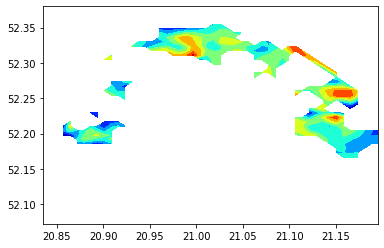

In [780]:
json_dict_summary, df_contour_summary=create_geojson(df_dec.lon_mod,df_dec.lat_mod,df_dec.KPI_Summary,20)

In [781]:
plot_geojson_countour(json_dict_summary, df_contour_summary, "Optimal location within budget and drivetime")